In [1]:
import numpy as np
import torch

import sys
sys.path.append('../')
import mvpy as mv

In [24]:
X = np.random.normal(size = (240, 60, 500))

%timeit mv.estimators.RSA().transform(X)

3.02 s ± 95.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
X = torch.normal(0, 1, size = (240, 60, 500))

%timeit mv.estimators.RSA().transform(X)

1.26 s ± 25.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
X = torch.normal(0, 1, size = (240, 60, 500), device = 'mps')

%timeit mv.estimators.RSA().transform(X)

1.15 s ± 29.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
X = torch.normal(0, 1, size = (10000, 60, 1))

%timeit mv.estimators.RSA().transform(X)

In [66]:
sys.path.append('../../../fabian_semantic_priors.nosync/analyses/exp4_eeg/')
sys.path.append('../../../fabian_semantic_priors.nosync/semantic_spaces/')
from subject_rerp_mt2 import load_eeg

In [3]:
import pandas as pd
import pubplot as pub
import data
import embeddings as emb
pub.styles.set()

C = pub.colours.equidistant('tab20c', k = 20)

In [67]:
base = '../../../fabian_semantic_priors.nosync/analyses/exp4_eeg/'

sub = data.Subjects['0035']
sid, pid = sub.sid, sub.pid

X, info = load_eeg(base + f'data/preprocessed/eeg/sub{sid}/rsa-MT1-epo.fif', fs = 200)
df = pd.read_csv(base + f'data/raw/beh/sub{sid}/{pid}.csv')
df = df.loc[(df.type == data.defs.TRIAL_PL1)].reset_index(drop = True)
df2 = pd.read_csv(base + f'data/raw/beh/sub{sid}/{pid}.csv')
df2 = df2.loc[(df2.type == data.defs.TRIAL_MT_MAIN)].reset_index(drop = True)

G = emb.glove.load_embedding(f_in = base + f'data/preprocessed/misc/glove/w2v_50D.txt')

In [68]:
device = 'cpu'
X = torch.from_numpy(X).to(torch.float32).to(device)
X = (X - X.mean((0, 2), keepdim = True)) * 1e6

In [69]:
cov = mv.estimators.Covariance(method = 'LedoitWolf').fit(X)
X_w = cov.transform(X)

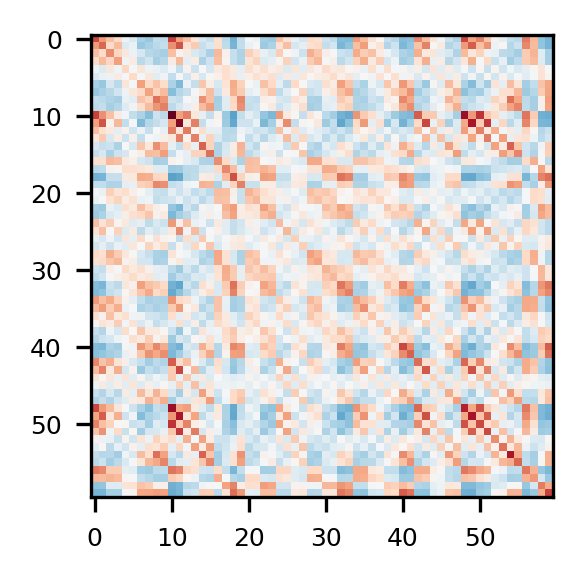

In [70]:
fig, ax = pub.figure()
vmax = torch.abs(cov.covariance_).max()
ax.imshow(cov.covariance_, vmin = -vmax, vmax = vmax, cmap = 'RdBu_r')

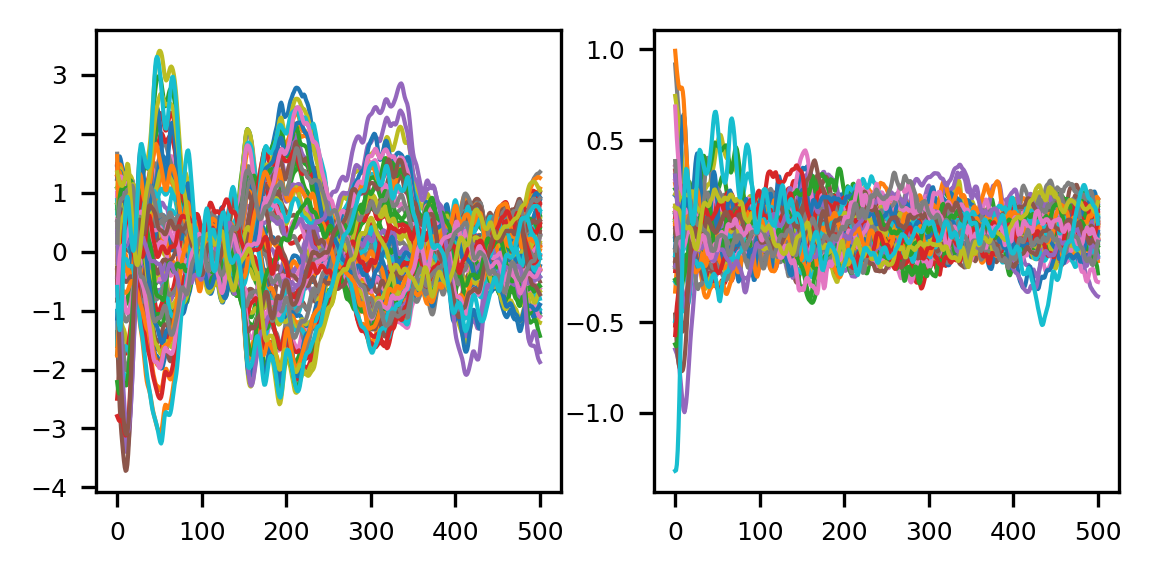

In [71]:
fig, ax = pub.figure(nrows = 1, ncols = 2)

for i in range(60):
    ax[0].plot(X[:,i,:].mean(0))
    ax[1].plot(X_w[:,i,:].mean(0))

In [72]:
targets = np.unique(df2.options_0.tolist() + df2.options_1.tolist())

word = []
audio = []
w2v2 = []
context = []

for i in range(len(df)):
    trial = df.loc[i]
    stim = trial.stimulus.split('/')[-1].split('.')[0]
    
    a, b = stim.split('_')[0].split('-')
    t, v = stim.split('_')[1]
    
    if (a not in targets) or (b not in targets):
        continue
    
    audio.append(np.load(base + f'data/preprocessed/audio/gt-200Hz/clear/{a}-{b}_{t}{v}.npy'))
    w2v2.append(np.load(base + f'data/preprocessed/audio/w2v2/reduced50_clear/{a}-{b}_{t}{v}_transformer_L12.npy'))
    
    if t == 'T':
        context.append(df2.loc[(df2.options_0 == a)].context.tolist()[0])
        word.append(a)
    else:
        context.append(df2.loc[(df2.options_0 == b)].context.tolist()[0])
        word.append(b)

word = np.array(word)
context = np.array(context)

unq_word, unq_count = np.unique(word, return_counts = True)

X_i = torch.zeros((2, unq_word.shape[0], 60, 501), dtype = torch.float32)
A_i = torch.zeros((2, unq_word.shape[0], 28, 501), dtype = torch.float32)
W_i = torch.zeros((2, unq_word.shape[0], 50, 501), dtype = torch.float32)
G_i = torch.zeros((2, unq_word.shape[0], 50, 501), dtype = torch.float32)

for i, (uword, ucount) in enumerate(zip(unq_word, unq_count)):
    indc = np.where(word == uword)[0]
    indc = torch.from_numpy(indc).to(torch.int32)
    
    X_i[:,i] = X[indc]
    G_i[:,i] = torch.from_numpy(G[uword.lower()].copy()[None,:,None]).to(torch.float32)
    
    for j, indx in enumerate(indc):
        A_i[j,i,:,100:100+audio[i].shape[1]] = torch.from_numpy(audio[i]).to(torch.float32)
        W_i[j,i,:,100:100+audio[i].shape[1]] = torch.from_numpy(w2v2[i][np.linspace(0, w2v2[i].shape[0]-1, audio[i].shape[1]).astype(int)]).to(torch.float32).T

In [73]:
d_neural = mv.estimators.RSA(estimator = mv.math.euclidean).transform(X_i.mean(0))
d_audio = mv.estimators.RSA(estimator = mv.math.euclidean).transform(A_i.mean(0))
d_w2v2 = mv.estimators.RSA(estimator = mv.math.euclidean).transform(W_i.mean(0))
d_glove = mv.estimators.RSA(estimator = mv.math.euclidean).transform(G_i.mean(0))

d_audio[torch.isnan(d_audio)] = 0
d_w2v2[torch.isnan(d_w2v2)] = 0

sim_ng = mv.math.pearsonr(d_neural.T, d_glove.T)
sim_na = mv.math.pearsonr(d_neural.T, d_audio.T)
sim_nw = mv.math.pearsonr(d_neural.T, d_w2v2.T)

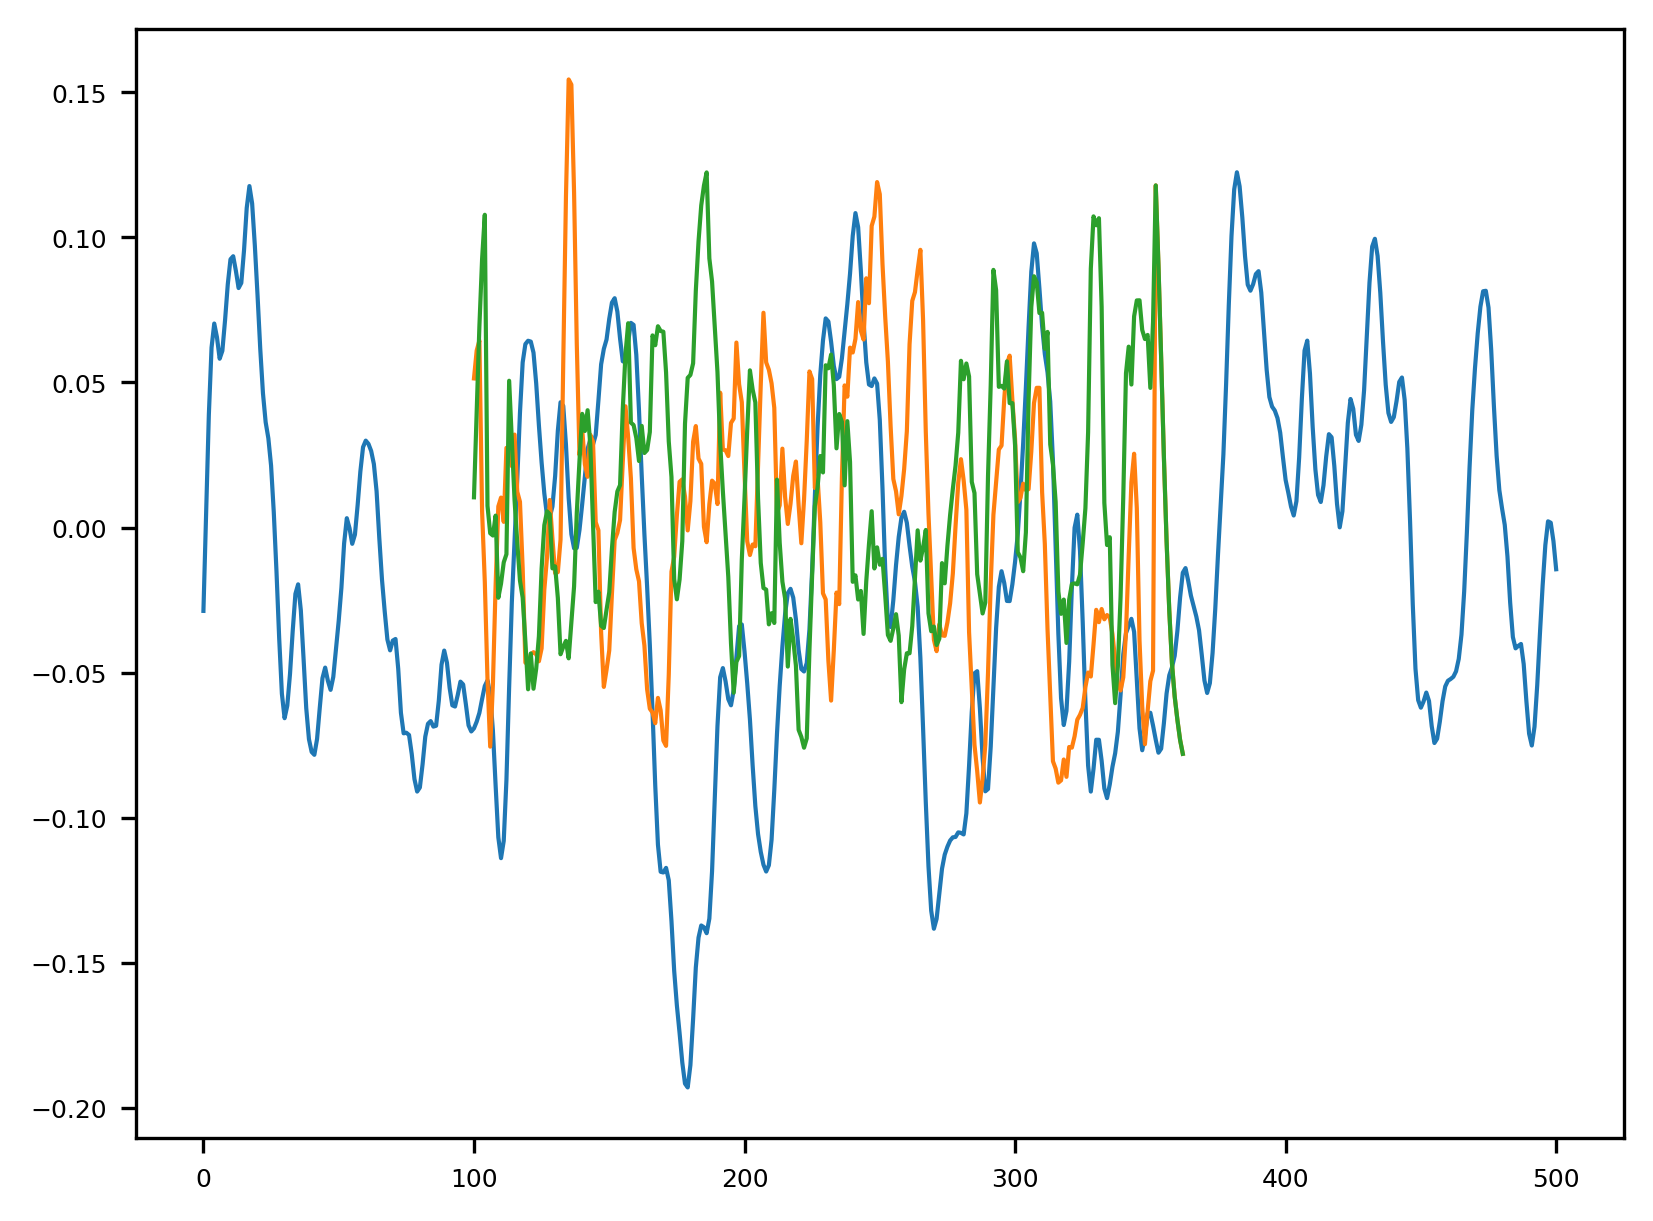

In [74]:
import matplotlib.pyplot as plt

plt.plot(sim_ng.numpy())
plt.plot(sim_na.numpy())
plt.plot(sim_nw.numpy())

In [29]:
cov_X = mv.estimators.Covariance(method = 'LedoitWolf').fit(X_i)
Σ_X = torch.linalg.inv(cov_X.covariance_)

In [30]:
cov_A = mv.estimators.Covariance(method = 'LedoitWolf').fit(A_i)
Σ_A = torch.linalg.inv(cov_A.covariance_)

In [31]:
cov_W = mv.estimators.Covariance(method = 'LedoitWolf').fit(W_i)
Σ_W = torch.linalg.inv(cov_W.covariance_)

In [32]:
cov_G = mv.estimators.Covariance(method = 'LedoitWolf').fit(G_i)
Σ_G = torch.linalg.inv(cov_G.covariance_)

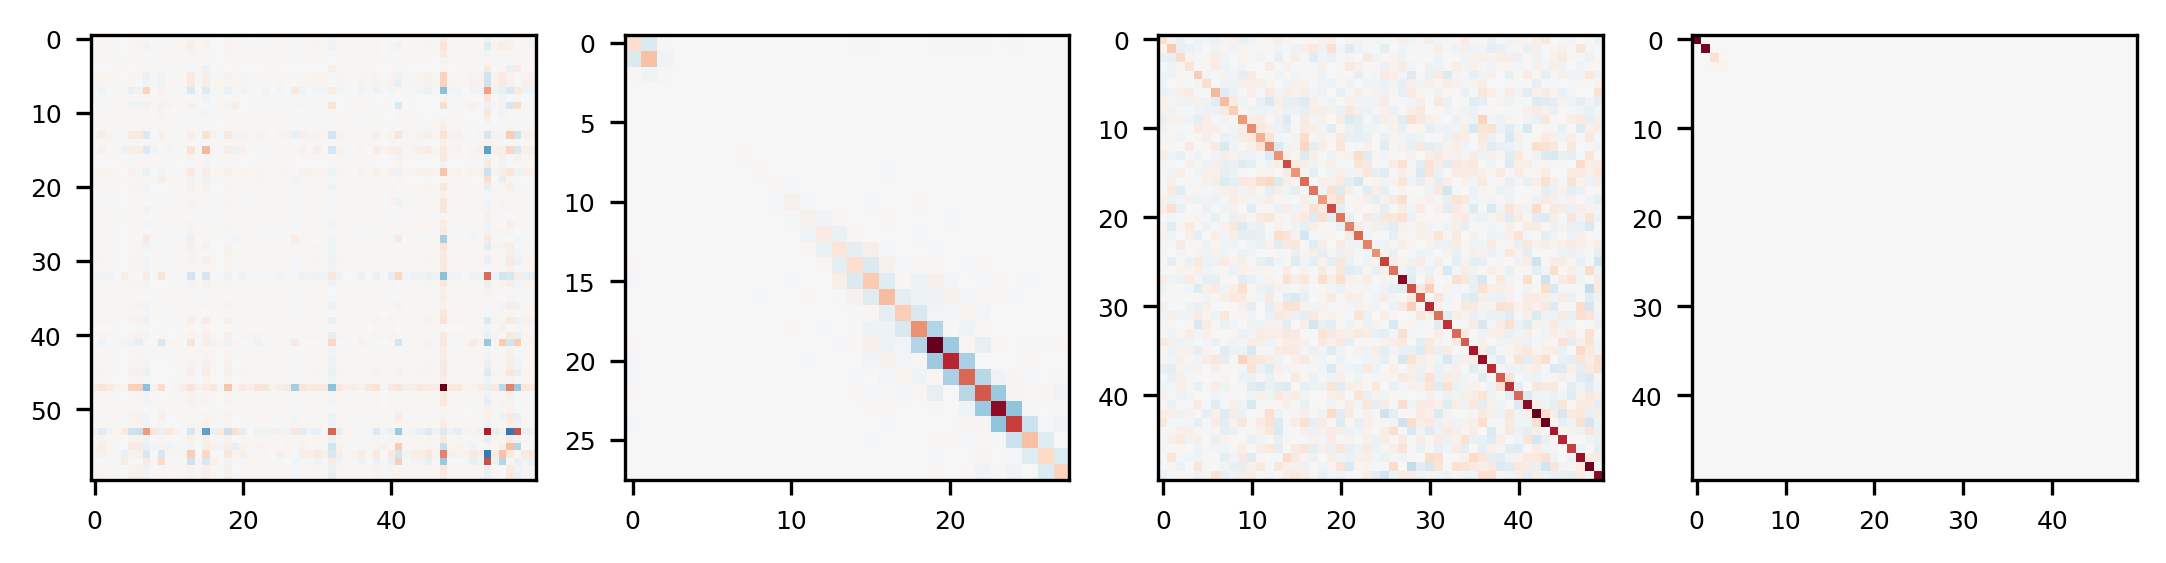

In [33]:
fig, ax = pub.figure(nrows = 1, ncols = 4)

vmax = torch.abs(Σ_X).max()
ax[0].imshow(Σ_X, vmin = -vmax, vmax = vmax, cmap = 'RdBu_r')

vmax = torch.abs(Σ_A).max()
ax[1].imshow(Σ_A, vmin = -vmax, vmax = vmax, cmap = 'RdBu_r')

vmax = torch.abs(Σ_W).max()
ax[2].imshow(Σ_W, vmin = -vmax, vmax = vmax, cmap = 'RdBu_r')

vmax = torch.abs(Σ_G).max()
ax[3].imshow(Σ_G, vmin = -vmax, vmax = vmax, cmap = 'RdBu_r')

In [40]:
d_neural = mv.estimators.RSA(grouped = True,
                             estimator = mv.math.cv_mahalanobis).transform(X_i, cov.covariance_)
d_audio = mv.estimators.RSA(grouped = True,
                            estimator = mv.math.cv_mahalanobis).transform(A_i, Σ_A)
d_w2v2 = mv.estimators.RSA(grouped = True,
                           estimator = mv.math.cv_mahalanobis).transform(W_i, Σ_W)
d_glove = mv.estimators.RSA(grouped = True,
                            estimator = mv.math.cv_mahalanobis).transform(G_i, Σ_G)

In [248]:
d_neural = mv.estimators.RSA(grouped = True,
                             estimator = mv.math.cv_euclidean).transform(X_i)
d_audio = mv.estimators.RSA(grouped = True,
                            estimator = mv.math.cv_euclidean).transform(A_i)
d_w2v2 = mv.estimators.RSA(grouped = True,
                           estimator = mv.math.cv_euclidean).transform(W_i)
d_glove = mv.estimators.RSA(grouped = True,
                            estimator = mv.math.cv_euclidean).transform(G_i)

In [41]:
sim_ng = mv.math.pearsonr(d_neural.T, d_glove.T)
sim_na = mv.math.pearsonr(d_neural.T, d_audio.T)
sim_nw = mv.math.pearsonr(d_neural.T, d_w2v2.T)

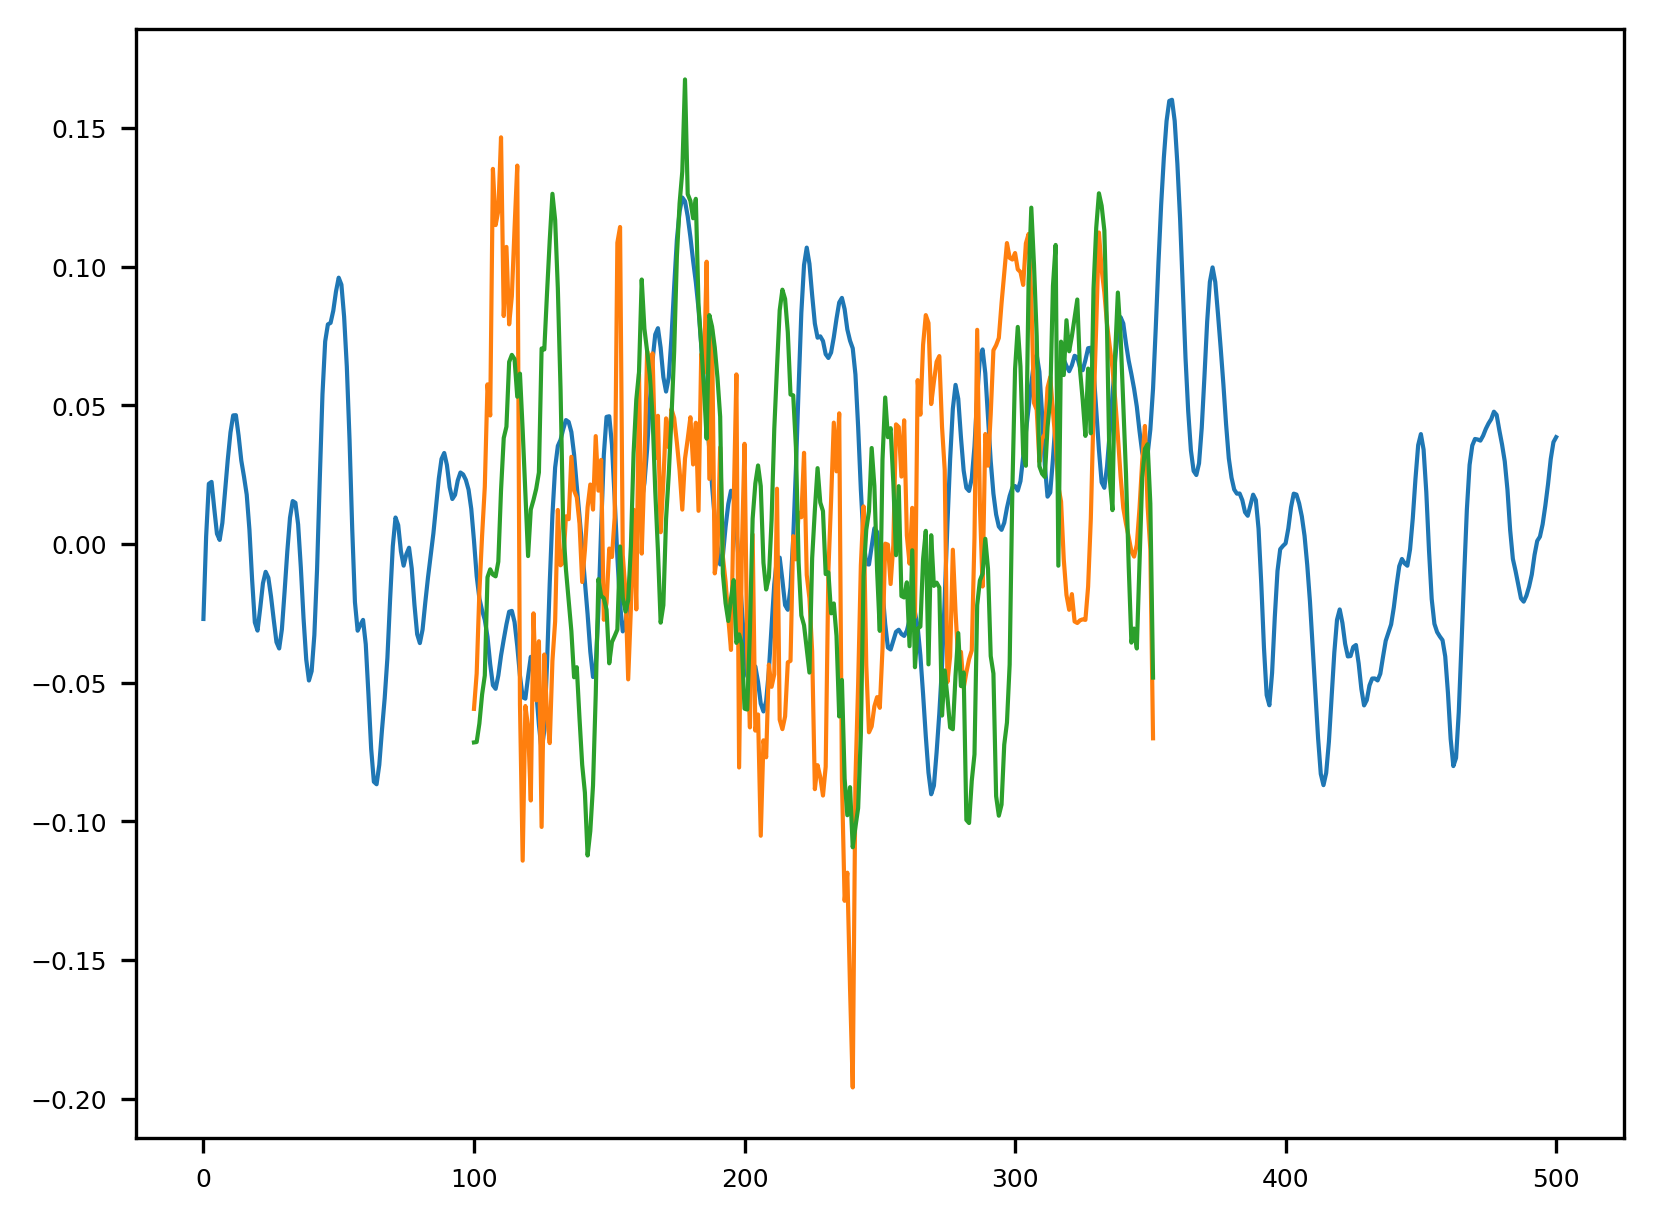

In [42]:
plt.plot(sim_ng.cpu().numpy())
plt.plot(sim_na.cpu().numpy())
plt.plot(sim_nw.cpu().numpy())

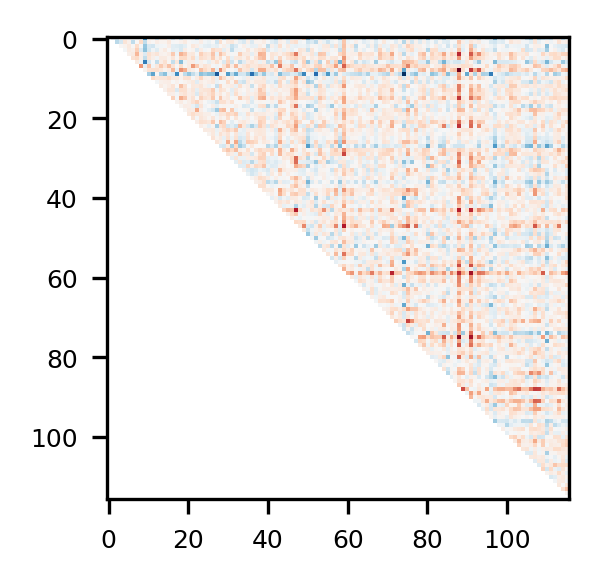

In [253]:
rdm = np.zeros((X_i.shape[1], X_i.shape[1], X_i.shape[-1])) * np.nan
x, y = np.triu_indices(X_i.shape[1], k = 1)
rdm[x,y,:] = d_neural.cpu().numpy()

fig, ax = pub.figure()
ax.imshow(rdm[:,:,150], cmap = 'RdBu_r')